Formalising the HET results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
hetpath = '/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/'

hetspecs = glob.glob('{}spectrum*d.fits'.format(hetpath)) #just the red arm
# hetspecs

In [164]:
# fits.getheader(hetspecs[1])

In [26]:
stars = []
for spec in hetspecs:
    data = fits.getdata(spec)
    star = fits.getheader(spec)['QOBJECT']
    # print(star)
    stars.append(star)
stars = np.unique(stars)
print(stars)

['WDJ0147+2339' 'WDJ0347+1624' 'WDJ0845+2257' 'WDJ0846+5703'
 'WDJ1622+5840']


Group spectra by star and date. Coadd spectra from the same date, and measure eqivalent widths.

In [134]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

def spectra_adder(f_array, e_array, rcs = True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    if rcs:
        rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux, error

def make_plot_spec(w, f, e, triplet_edges, waveband=[8400, 8800], smooth=10): #cuts spectrum down to the bit to plot
    """
    Normalises the spectrum around the Caii lines. Waveband is the strech of spectrum to return. Triplet gives the regions to include when normalising.
    """
    fitter = fitting.LinearLSQFitter()
    tripmask = (w > triplet_edges[0]) & (w < triplet_edges[1]) | (w > triplet_edges[2]) & (w < triplet_edges[3]) | (w > triplet_edges[4]) & (w < triplet_edges[5]) | (w > triplet_edges[6]) & (w < triplet_edges[7])  
    w1, f1, e1 = w[tripmask], f[tripmask], e[tripmask]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    nf = f/n_fit(w)
    ne = e/n_fit(w)
    if smooth == 0:
        smooth = 1
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    bandmask = (w >= waveband[0]) & (w < waveband[1])
    w1, f1, e1 = w[bandmask], nf[bandmask], ne[bandmask]
    return w1,f1, e1

def norm_equivalent_width(w, f, e, bandpass):
    """
    Measures the equivalent width of a continumn-normalised spectrum in the gap bandpass
    """
    mask = (w >= bandpass[0]) & (w <= bandpass[1]) 
    w, f, e = w[mask], f[mask], e[mask]
    w0, w1 = wavelength_edges(w)
    eqw = np.sum((1-f)*(w1-w0))
    eqw_e=((1.+(1./np.mean(f)))**(0.5)) * (((w[-1]-w[0])-eqw)/(np.mean(f)/np.mean(e)))
    return eqw, eqw_e

In [135]:
triplet_regions = {'WDJ0846+5703':[8435, 8480, 8520, 8522, 8565, 8638, 8685, 8750],
                   'WDJ0845+2257':[8400, 8480, 8522, 8525, 8565, 8642,8685,8750],
                   'WDJ0347+1624':[8400, 8475, 8515, 8522, 8565, 8640, 8685, 8750],
                   'WDJ0147+2339':[8400, 8475, 8521, 8522, 8565, 8635, 8690, 8750],
                   'WDJ1622+5840':[8400, 8470, 8520, 8521, 8570, 8635, 8690, 8750]}
triplet_regions
                   




{'WDJ0846+5703': [8435, 8480, 8520, 8522, 8565, 8638, 8685, 8750],
 'WDJ0845+2257': [8400, 8480, 8522, 8525, 8565, 8642, 8685, 8750],
 'WDJ0347+1624': [8400, 8475, 8515, 8522, 8565, 8640, 8685, 8750],
 'WDJ0147+2339': [8400, 8475, 8521, 8522, 8565, 8635, 8690, 8750],
 'WDJ1622+5840': [8400, 8470, 8520, 8521, 8570, 8635, 8690, 8750]}

WDJ0147+2339
2021-12-16
2022-01-03


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


2022-01-17


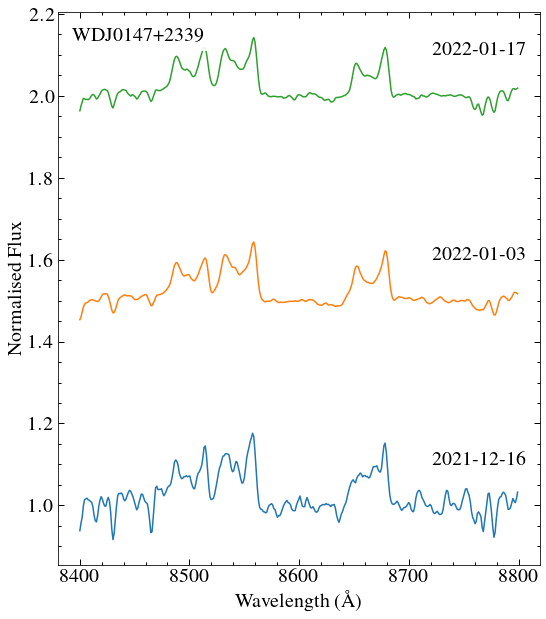

WDJ0347+1624
2022-02-09
2022-02-11


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


2022-02-21


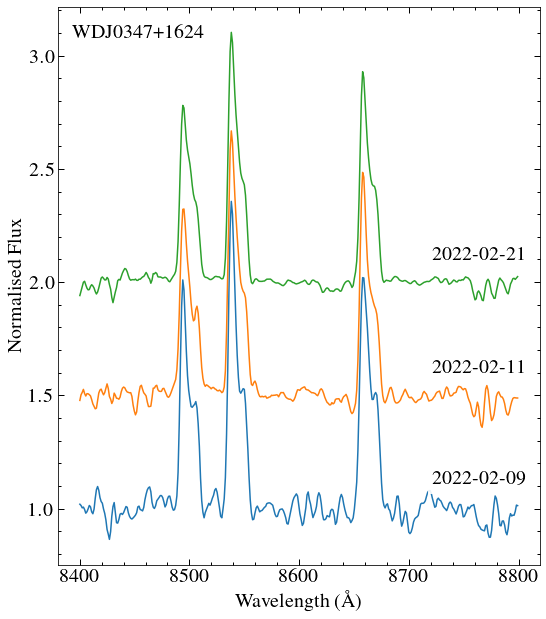

WDJ0845+2257
2021-12-29
2022-01-23


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


2022-02-10
2022-02-27


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


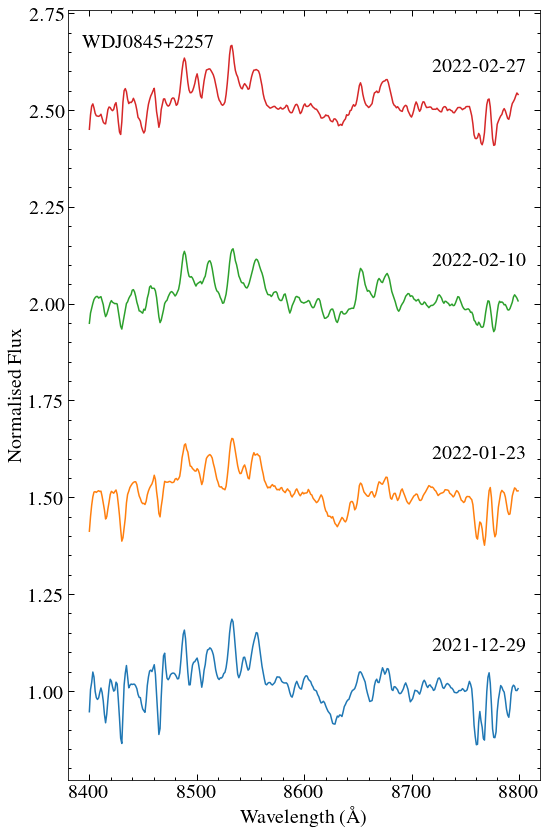

WDJ0846+5703
2022-02-10
2022-02-28


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


2022-03-11


 [astropy.modeling.fitting]


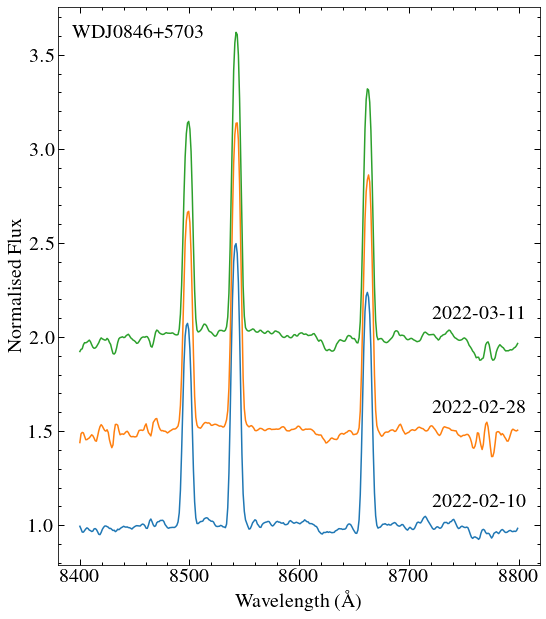

WDJ1622+5840
2022-02-13


 [astropy.modeling.fitting]


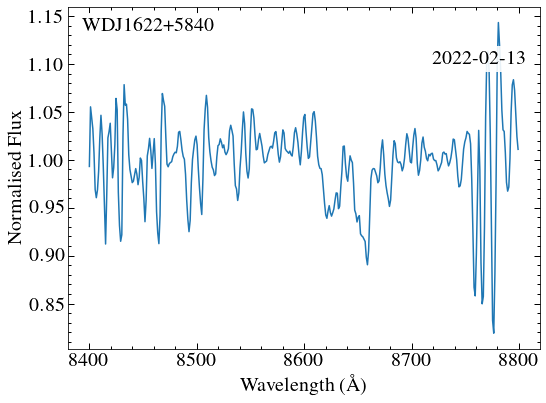

In [147]:
smooth = 4
for star in stars:
    mjds = []
    equivalent_widths  = []
    equivalent_width_errors = []
    
    print(star)
    dates = []
    for spec in hetspecs:
        hdr = fits.getheader(spec)
        if hdr['QOBJECT'] == star:
            dates.append(hdr['DATE-OBS'])
    dates = np.unique(dates)
    dates = dates[np.argsort(dates)]
    ysize = max([len(dates)*3, 6])
    plt.figure(figsize=(8, ysize))
    for i, date in enumerate(dates):
        print(date)
        fs  = [] #arrays to put fluxes and errors in to coadd, wavelength grid is the same for each spectrum
        es = []
        for spec in hetspecs:
            hdr = fits.getheader(spec)
            if hdr['DATE-OBS'] == date and hdr['QOBJECT'] == star and hdr['WAVE0'] > 8000:
                data = fits.getdata(spec)
                w, fi, ei = data[0], data[1], data[3]
                fs.append(fi)
                es.append(ei)
        if len(np.array(fs)) >1:
            f, e = spectra_adder(np.array(fs), np.array(es), rcs = True)
        else:
            f, e = fi, ei
        trips = triplet_regions[star]
        # mask = (w > 8400) & (w < 8750)
        nw,nf, ne = make_plot_spec(w, f, e, triplet_regions[star], smooth=4)
        scale = 1
        if max(nf < 1.5):
            scale=0.5
        
        plt.plot(nw, nf+i*scale)
        plt.annotate(date, (0.97, 1.1+i*scale), xycoords= ('axes fraction', 'data'), ha='right', bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
        

        
             
    
        date = Time(date)
        mjds.append(date.mjd)
        eqws = []
        eqwes = []
        for b, r in zip(trips[1::2][:-1], trips[2::2]):
            eqw, eqwe = norm_equivalent_width(nw, nf, ne, [b,r])
            eqws.append(eqw)
            eqwes.append(eqwe)
        
        equivalent_widths.append(np.sum(eqws))
        equivalent_width_errors.append(np.sum(np.array(eqwes)**2)**0.5)
    
    # [plt.axvline(line, ls='--', c='C4') for line in triplet_regions[star][1:-1]]
    # plt.axhline(1, ls='--', c='0.5')
    plt.annotate(star, (0.03, 0.97), xycoords= ('axes fraction'), ha='left', va='top', bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
    plt.xlabel('Wavelength (\AA)')
    plt.ylabel('Normalised Flux')
    plt.tight_layout()
    plt.savefig('plots/{}_lrs2_caiitriplets.png'.format(star), facecolor='w')
    plt.savefig('plots/{}_lrs2_caiitriplets.pdf'.format(star))
    plt.show()
            
    # plt.errorbar(mjds,  equivalent_widths, yerr=equivalent_width_errors, marker='o', ls='none')
    # plt.axhline(0, ls='--', c='0.5')

    savdat = Table([mjds, equivalent_widths, equivalent_width_errors], names = ['#MJD', 'EW', 'EW_ERROR'])
    ascii.write(savdat, 'het_results/{}_lrs2_ews.dat'.format(star), format='basic', overwrite=True)

    # plt.show()
    

                

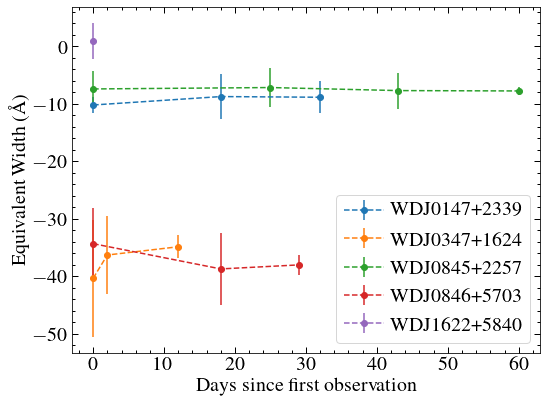

In [163]:
plt.figure(figsize=(8,6))
for star in stars:
    mjd, ew, ewe = np.loadtxt('het_results/{}_lrs2_ews.dat'.format(star), unpack=True)
    if type(mjd) == np.ndarray:
        mjd -=mjd[0]
    else:
        mjd=0
    plt.errorbar(mjd, ew, yerr=ewe, ls='--', marker='o', label=star)
plt.legend(frameon = True)
plt.xlabel('Days since first observation')
plt.ylabel ('Equivalent Width (\AA)')
plt.tight_layout()
plt.savefig('plots/all_lrs_ews.png', facecolor='w')
plt.savefig('plots/all_lrs_ews.pdf')